# Structural Connectivity Analysis

In [2]:
# IMPORT LIBS

%pylab nbagg
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
from scipy import io as sio
sns.set_theme()
import warnings; warnings.filterwarnings('ignore')
import networkx as nx
import warnings
import pandas as pd
import numpy as np
from scipy import stats
import small_world_propensity as swp
import random
from tvb.datatypes import connectivity
import diptest
import powerlaw

%matplotlib inline
mpl.style.use('default')


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [145]:
#upload control connectome
df = pd.read_csv(r"C:\Users\leona\Leo_Python\connectome_control.csv", sep=',', header=None)
mat_control = df.to_numpy()
mat_control.shape
#upload asd weights
df = pd.read_csv(r"C:\Users\leona\Leo_Python\sub-01_parcels_coreg_connectome.csv", sep=',', header=None)
matrix = df.to_numpy()
matrix.shape
#upload asd tract lenghts
df = pd.read_csv(r"C:\Users\leona\Leo_Python\sub-01_parcels_coreg_meanlength.csv", sep=',', header=None)
matrix_l = df.to_numpy()
#upload asd conduction velocities
df = pd.read_csv(r"C:\Users\leona\Leo_Python\sub-01_parcels_coreg_meanvelocity.csv", sep=',', header=None)
matrix_v = df.to_numpy()
matrix_v.shape
#upload tvb default connectivity - uncomment to compare also tvb connectome-
#con =  connectivity.Connectivity.from_file('connectivity_76.zip')
#tvb = con.weights


(379, 379)

In [5]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [6]:
#extract triangular part, disregard null connections, extract statistics and compute time delays


n = 379
n_tr = int(n*(n-1)/2)
mat_v_tr = np.zeros([n_tr])
mat_l_tr = np.zeros([n_tr])
mat_w_tr = np.zeros([n_tr])
z = -1
for i in range (1,n):
    for j in range (0,i):
        z = z + 1
        mat_v_tr[z] = matrix_v[i,j]
        mat_l_tr[z] = matrix_l[i,j]
        mat_w_tr[z] = matrix[i,j]
            

#mat_v_tr = NormalizeData(mat_v_tr)
mat_v_tr = mat_v_tr[mat_v_tr !=0]
mat_l_tr = mat_l_tr[mat_l_tr !=0]
mat_w_tr = mat_w_tr[mat_w_tr !=0]
mean = mat_v_tr.mean()
a = 10/mean
mat_v_tr = mat_v_tr * a
times = np.divide(mat_l_tr, mat_v_tr)
#mat_v_tr = mat_v_tr[~numpy.isnan(mat_v_tr)]

max = mat_v_tr.max()
mean = mat_v_tr.mean()
times_cc = mat_l_tr / (max)
times_cc = times_cc[times_cc != 0]
times_c = mat_l_tr / mean
times_c = times_c[times_c != 0]
times = times[~numpy.isnan(times)]

In [7]:
#extract subdvision between interhemispheric and intrahemispheric

z = 0
v_inter = np.zeros([35721])

for i in range (189,378):
    for j in range (0,189):
        v_inter[z] = matrix_v[i,j]
        z = z+1
z = 0
v_intra = np.zeros([35532])
for i in range (1,189):
    for j in range (0,i):
        v_intra[z] = matrix_v[i,j]
        z = z+1
for i in range (189,378):
    for j in range (189,i):
        v_intra[z] = matrix_v[i,j]
        z = z+1


n = 379
n_tr = int(n*(n-1)/2)
mat_v_tr = np.zeros([n_tr])

z = -1
for i in range (1,n):
    for j in range (0,i):
        z = z + 1
        mat_v_tr[z] = matrix_v[i,j]
        
mat_v_tr = mat_v_tr[mat_v_tr !=0]
v_inter = v_inter[v_inter !=0]
v_intra = v_intra[v_intra !=0]


Text(0.5, 0, 'Tract Lengths')

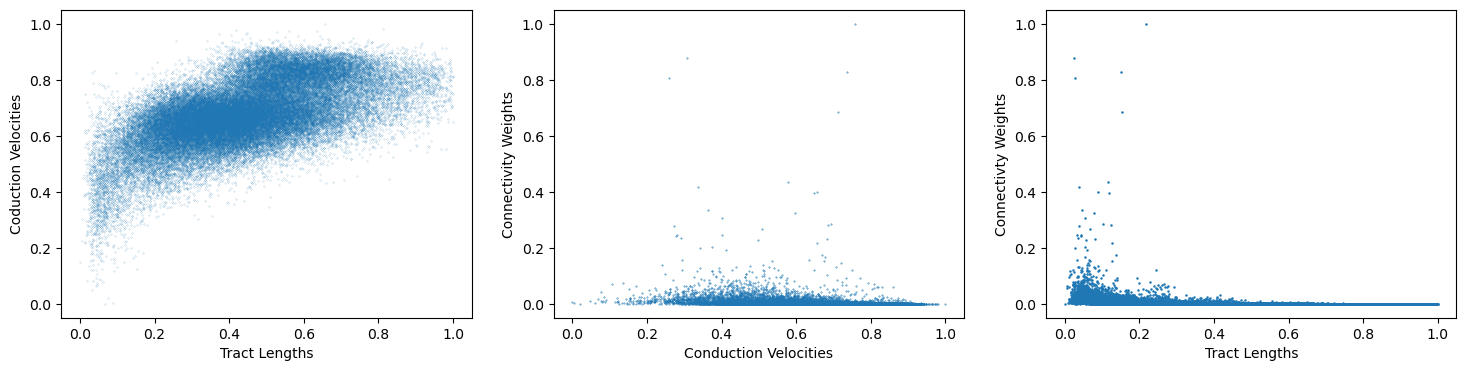

In [51]:
#plot scatter of the 3 matrices

plt.figure(figsize = (18,4))

plt.subplot(1,3,1)
x = NormalizeData(mat_l_tr)
y = NormalizeData(mat_v_tr)
plt.scatter(x,y, marker = '.', s = 0.05)
plt.ylabel('Coduction Velocities')
plt.xlabel('Tract Lengths')
plt.subplot(1,3,2)

x = NormalizeData(mat_w_tr)
y = NormalizeData(mat_v_tr)
plt.scatter(y,x, marker = '.', s = 0.5)
plt.xlabel('Conduction Velocities')
plt.ylabel('Connectivity Weights')

plt.subplot(1,3,3)

x = NormalizeData(mat_l_tr)
y = NormalizeData(mat_w_tr)
plt.scatter(x,y, marker = '.', s = 2.5)
plt.ylabel('Connectivty Weights')
plt.xlabel('Tract Lengths')


Text(0.5, 0, 'Tract Lengths')

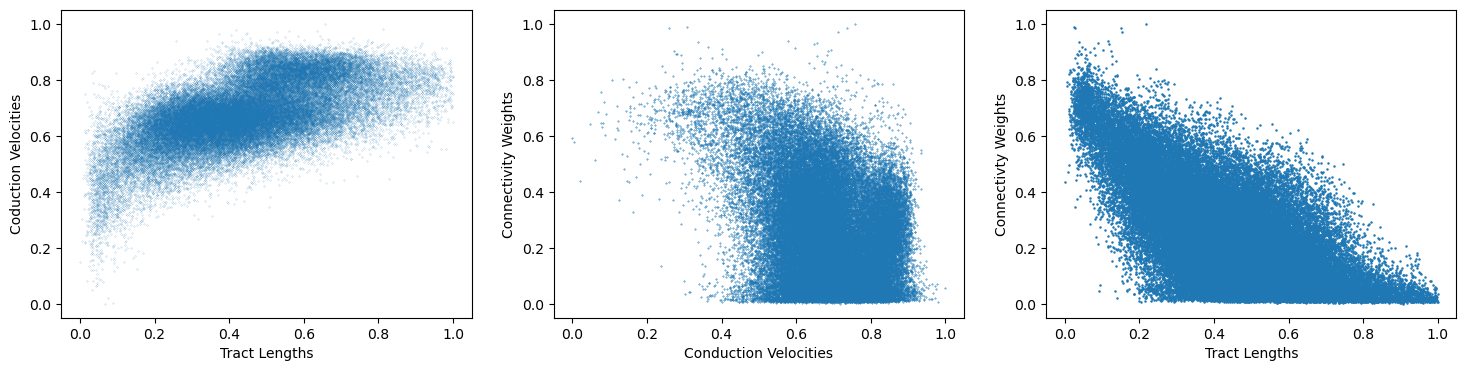

In [17]:
#plot scatter of the 3 matrices taking log(1+w) for the weights

plt.figure(figsize = (18,4))

plt.subplot(1,3,1)
x = NormalizeData(mat_l_tr)
y = NormalizeData(mat_v_tr)
plt.scatter(x,y, marker = '.', s = 0.05)
plt.ylabel('Coduction Velocities')
plt.xlabel('Tract Lengths')
plt.subplot(1,3,2)

x = NormalizeData(np.log(1+mat_w_tr))
y = NormalizeData(mat_v_tr)
plt.scatter(y,x, marker = '.', s = 0.5)
plt.xlabel('Conduction Velocities')
plt.ylabel('Connectivity Weights')

plt.subplot(1,3,3)

x = NormalizeData(mat_l_tr)
y = NormalizeData(np.log(1+mat_w_tr))
plt.scatter(x,y, marker = '.', s = 2.5)
plt.ylabel('Connectivty Weights')
plt.xlabel('Tract Lengths')


In [40]:
#test bimodality
dip, pval = diptest.diptest(mat_v_tr)
dip,pval

(0.00080297410005857, 0.9971751062561925)

Text(0.5, 1.0, 'Intra vs Inter Hemispherical Contributions')

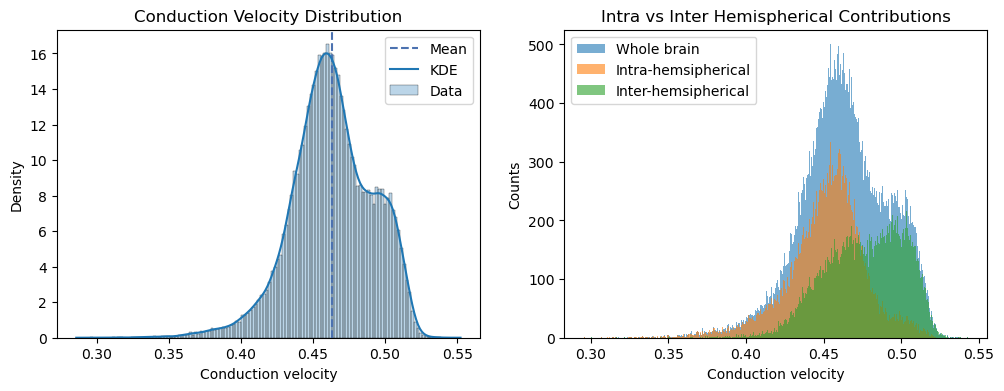

In [45]:
#inspect the bimodal conduction velocity distribution according to intra vs inter hemispherci


plt.figure(figsize = (12,4))

plt.subplot(1,2,1)
sns.histplot(data=mat_v_tr, stat = 'density', label='Data', alpha = 0.3)
plt.axvline(x = mat_v_tr.mean(), color = 'b', linestyle = '--', label = 'Mean')
plt.xlabel('Conduction velocity')
sns.kdeplot(data=mat_v_tr, label='KDE')
plt.legend()
plt.title('Conduction Velocity Distribution')

plt.subplot(1,2,2)

plt.hist(mat_v_tr, bins = 500, label = 'Whole brain', alpha = 0.6)
plt.hist(v_intra, bins = 500, label = 'Intra-hemsipherical', alpha = 0.6)
plt.hist(v_inter, bins = 500, label = 'Inter-hemsipherical', alpha = 0.6)
plt.legend()
plt.xlabel('Conduction velocity')
plt.ylabel('Counts')
plt.title('Intra vs Inter Hemispherical Contributions')

Text(0.5, 1.0, 'Time Delays Correction')

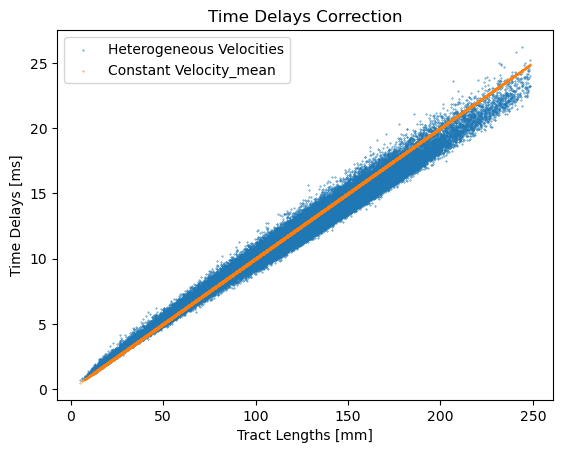

In [23]:
#compare time delays with the two method - homogeneous vs heterogeneous in function of tract lenghts
x = mat_l_tr
y = times
z = times_c
plt.scatter(x,y, marker = '.', s = 0.5, label = 'Heterogeneous Velocities')
plt.scatter(x,z, marker = '.', s = 0.5, label = 'Constant Velocity_mean')
plt.ylabel('Time Delays [ms]')
plt.xlabel('Tract Lengths [mm]')
plt.legend()
plt.title('Time Delays Correction')

Text(0.5, 1.0, 'Time Delays Comparison')

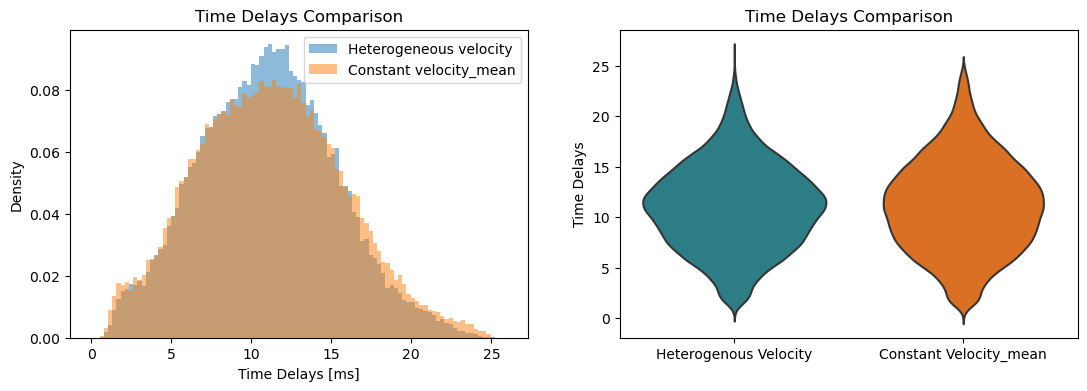

In [36]:
#compare time delay distributions

plt.figure(figsize = (13,4))

plt.subplot(1,2,1)
x = times
y = times_c
bins = numpy.linspace(0,26, 100)
#fig = plt.figure()
pyplot.hist(x, bins, alpha=0.5, label='Heterogeneous velocity', density=True)
pyplot.hist(y, bins, alpha=0.5, label='Constant velocity_mean', density=True)
pyplot.legend(loc='upper right')
plt.ylabel('Density')
plt.xlabel('Time Delays [ms]')
plt.title('Time Delays Comparison')
#pyplot.show()

plt.subplot(1,2,2)

time_d = np.zeros([57621,2])
time_d[:,0] = x
time_d[:,1] = y


# build a dataframe object and plot box and swarm
subjects = ['Heterogenous Velocity','Constant Velocity_mean']
df = pd.DataFrame(time_d[:,:], columns = subjects) 
colors = ['#24838d','#e96d13']
sns.violinplot(data=df, palette = colors, inner = None, saturation = 0.85)
plt.title('')
plt.ylabel('Time Delays')
plt.title('Time Delays Comparison')




In [46]:
#test statistical difference with Kolmogorov-Smirnov test for time delays distributions

stats.ks_2samp(times, times_c)


KstestResult(statistic=0.030266743027715592, pvalue=2.3112616004868433e-23, statistic_location=14.576224316489531, statistic_sign=1)

In [49]:
#compare pairwise time delays
l = int(times.shape[0])
z = 0
for i in range (l):
    if times[i] > times_c[i]:
        z = z+1
z/l*100  


50.972735634577674

## Weights distribution Analysis


In [52]:
#function that extract the two hemispheres

def emispheres(A):
    
    z = -1
    k = -1
    H_l = np.zeros([189,379])
    H_left = np.zeros([189,189])
    H_r = np.zeros([189,379])
    H_right = np.zeros([189,189])
    for i in range (378):
        a = int(i)
        if a < 180 or 359 < a < 369:
            z = z+1
            H_l[z,:]= A[a,:]
        else:
            k = k+1
            H_r[k,:]= A[a,:]
    z = -1
    k = -1
    for i in range (378):
        a = int(i)
        if a < 180 or 359 < a < 369:
            z = z+1
            H_left[:,z]= H_l[:,a]
        else:
            k = k+1
            H_right[:,k]= H_r[:,a]
    return H_left,H_right

In [53]:
#compute the two hemispheric weights matrices for both asd and control

H_left, H_right = emispheres(matrix)
H_left_control, H_right_control = emispheres(mat_control)

In [54]:
#extract the triangular part of the structural matrix

mat = matrix
mat_c = mat_control
n_nodes = (mat.shape[0])
mat_tr = np.zeros([int(n_nodes*(n_nodes-1)/2)])
mat_c_tr = np.zeros([int(n_nodes*(n_nodes-1)/2)])
z = -1
for i in range (1,n_nodes):
    for j in range (0,i):
        z = z + 1
        mat_tr[z] = mat[i,j]
        mat_c_tr[z] = mat_c[i,j]
  
mat_right = H_right
mat_left = H_left
mat_c_right = H_right_control
mat_c_left = H_left_control
n_nodes_h = (mat_right.shape[0])
mat_tr_right = np.zeros([int(n_nodes_h*(n_nodes_h-1)/2)])
mat_tr_left = np.zeros([int(n_nodes_h*(n_nodes_h-1)/2)])
mat_c_tr_right = np.zeros([int(n_nodes_h*(n_nodes_h-1)/2)])
mat_c_tr_left = np.zeros([int(n_nodes_h*(n_nodes_h-1)/2)])
z = -1
for i in range (1,n_nodes_h):
    for j in range (0,i):
        z = z + 1
        mat_tr_right[z] = mat_right[i,j]
        mat_tr_left[z] = mat_left[i,j]
        mat_c_tr_right[z] = mat_c_right[i,j]
        mat_c_tr_left[z] = mat_c_left[i,j]

In [55]:
#POWERLAW FIT- fit the tail of distrbiution with MLE method for inference on the power law exponent 
#for whole brain, left and right hemispheres of asd connectome

results = powerlaw.Fit(mat_tr)#, discrete = 'True')
alpha = results.power_law.alpha
x_min = results.power_law.xmin

results_left = powerlaw.Fit(mat_tr_left)#, discrete = 'True')
alpha_left = results_left.power_law.alpha
x_min_left = results_left.power_law.xmin

results_right = powerlaw.Fit(mat_tr_right)#, discrete = 'True')
alpha_right = results_right.power_law.alpha
x_min_right = results_right.power_law.xmin
print(alpha, x_min, alpha_left, x_min_left, alpha_right, x_min_right)

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


2.739091312924416 22081.0534486175 2.7648023599056306 20015.6815647781 2.9845969611304137 25125.8827491999


In [56]:
#compute the same for the control connectome

results_c = powerlaw.Fit(mat_c_tr)#, discrete = 'True')
alpha_c = results_c.power_law.alpha
x_min_c = results_c.power_law.xmin

results_c_left = powerlaw.Fit(mat_c_tr_left)#, discrete = 'True')
alpha_c_left = results_c_left.power_law.alpha
x_min_c_left = results_c_left.power_law.xmin

results_c_right = powerlaw.Fit(mat_c_tr_right)#, discrete = 'True')
alpha_c_right = results_c_right.power_law.alpha
x_min_c_right = results_c_right.power_law.xmin
print(alpha_c, x_min_c, alpha_c_left, x_min_c_left, alpha_c_right, x_min_c_right)

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


2.8855065520731378 46243.7149261981 3.335494936346164 85279.8574045151 2.9540995632570968 47980.8435333818


In [57]:
#comparison with alterantive heavy tail distributions - output R: loglikelihood ratio, p: associated p-value

R, p = results.distribution_compare('power_law', 'stretched_exponential', normalized_ratio=True)
R2, p2 = results.distribution_compare('power_law', 'lognormal_positive', normalized_ratio=True)
R3, p3 = results.distribution_compare('power_law', 'exponential', normalized_ratio=True)
R4, p4 = results.distribution_compare('power_law', 'truncated_power_law', normalized_ratio=True)

R,p,R2,p2,R3,p3,R4,p4

Assuming nested distributions


(1.0389483346551265,
 0.29882876528578406,
 0.6959914285279802,
 0.4864341976821507,
 4.153626359194585,
 3.272473689585317e-05,
 -0.2708080598848359,
 0.8131942441579589)

In [58]:
# the same can be done for hemispheric connectivity only

R_r, p_r = results_right.distribution_compare('power_law', 'stretched_exponential', normalized_ratio=True)
R2_r, p2_r = results_right.distribution_compare('power_law', 'lognormal_positive', normalized_ratio=True)
R3_r, p3_r = results_right.distribution_compare('power_law', 'exponential', normalized_ratio=True)
R4_r, p4_r = results_right.distribution_compare('power_law', 'truncated_power_law', normalized_ratio=True)

R_r,p_r,R2_r,p2_r,R3_r,p3_r,R4_r, p4_r

Assuming nested distributions


(0.6284123001366031,
 0.5297338814530124,
 0.36389730035813267,
 0.7159347006573472,
 2.2091623891616137,
 0.027163347888823033,
 -0.13104041064452504,
 0.88429527089117)

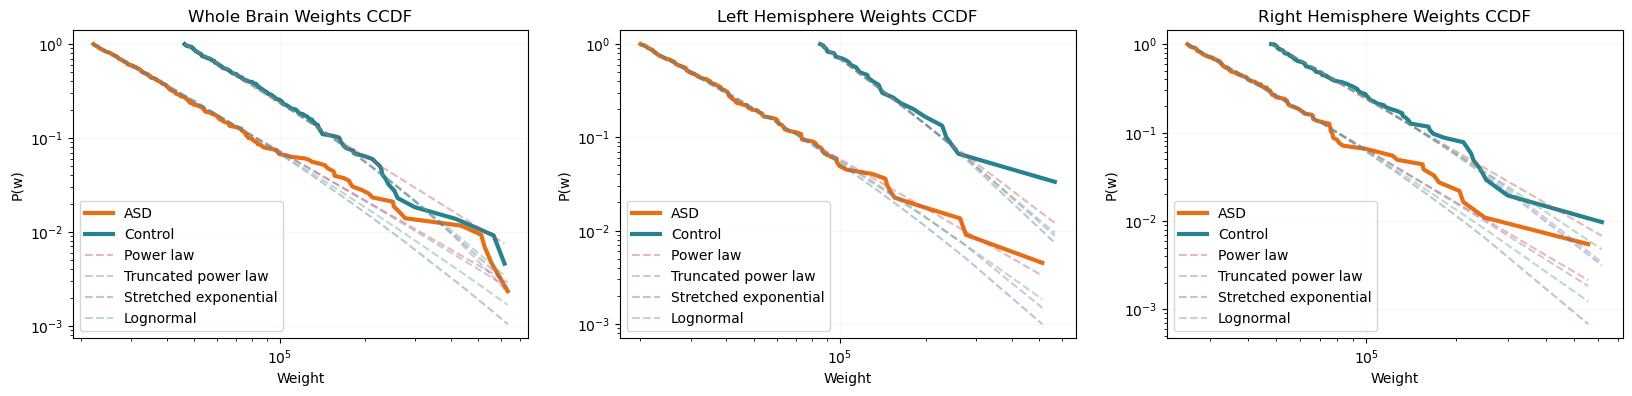

In [59]:
# PLOTTING CONTROL AND ASD WEIGHTS CCDF DISTRBIUTIONS TOGETHER WITH FITTED MODELS AND ALTERNATIVE COMPARISON


fig = plt.figure(figsize = (20,4))
#fig.set_facecolor("#F7F7F7")
colors = ['#24838d','#e96d13']

plt.subplot(1,3,1)

fig1 = results.plot_ccdf(linewidth=3, label = 'ASD', color = colors[1])  # original_data = 'True',
fig1 = results_c.plot_ccdf(linewidth=3, label = 'Control', color = colors[0])  # original_data = 'True',
results.power_law.plot_ccdf(ax = fig1, color = 'r', linestyle='--', label= 'Power law', alpha = 0.4 )
results_c.power_law.plot_ccdf(ax = fig1, color = 'r', linestyle='--', alpha = 0.4)
results.truncated_power_law.plot_ccdf(ax = fig1, color='m', linestyle='--', label= 'Truncated power law', alpha = 0.4)
results.stretched_exponential.plot_ccdf(ax = fig1, color='b', linestyle='--', label= 'Stretched exponential', alpha = 0.4)
results.lognormal_positive.plot_ccdf(ax = fig1, color='g', linestyle='--', label= 'Lognormal', alpha = 0.4)
results_c.truncated_power_law.plot_ccdf(ax = fig1, color='m', linestyle='--', alpha = 0.4)
results_c.stretched_exponential.plot_ccdf(ax = fig1, color='b', linestyle='--', alpha = 0.4)
results_c.lognormal_positive.plot_ccdf(ax = fig1, color='g', linestyle='--', alpha = 0.4)
#results.exponential.plot_ccdf(ax = fig1, color='y', linestyle='--', label= 'Exponential fit')
#results_c.exponential.plot_ccdf(ax = fig1, color='y', linestyle='--')
plt.grid(color = "#F7F7F7")
fig1.set_facecolor("white")
plt.setp(fig1.spines.values(), color='black')
#plt.xlim(32000,1000000)

plt.title('Whole Brain Weights CCDF')
plt.ylabel('P(w)')
plt.xlabel('Weight')
plt.legend(loc="lower left")
 
plt.subplot(1,3,2)
fig2 = results_left.plot_ccdf(linewidth=3, label = 'ASD', color = colors[1])  # original_data = 'True',
fig2 = results_c_left.plot_ccdf(linewidth=3, label = 'Control', color = colors[0])  # original_data = 'True',
results_left.power_law.plot_ccdf(ax = fig2, color = 'r', linestyle='--',label= 'Power law' , alpha = 0.4 )
results_c_left.power_law.plot_ccdf(ax = fig2, color = 'r', linestyle='--', alpha = 0.4 )
results_left.truncated_power_law.plot_ccdf(ax = fig2, color='m', linestyle='--', label= 'Truncated power law', alpha = 0.4)
results_left.stretched_exponential.plot_ccdf(ax = fig2, color='b', linestyle='--', label= 'Stretched exponential', alpha = 0.4)
results_left.lognormal_positive.plot_ccdf(ax = fig2, color='g', linestyle='--', label= 'Lognormal', alpha = 0.4)
results_c_left.truncated_power_law.plot_ccdf(ax = fig2, color='m', linestyle='--', alpha = 0.4)
results_c_left.stretched_exponential.plot_ccdf(ax = fig2, color='b', linestyle='--', alpha = 0.4)
results_c_left.lognormal_positive.plot_ccdf(ax = fig2, color='g', linestyle='--', alpha = 0.4)
#results_left.exponential.plot_ccdf(ax = fig2, color='y', linestyle='--', label= 'Exponential fit')
#results_c_left.exponential.plot_ccdf(ax = fig2, color='y', linestyle='--')
plt.grid(color = "#F7F7F7")
fig2.set_facecolor("white")
plt.setp(fig2.spines.values(), color='black')
#plt.xlim(57000,1000000)

plt.title('Left Hemisphere Weights CCDF')
plt.ylabel('P(w)')
plt.xlabel('Weight')
plt.legend(loc="lower left")


plt.subplot(1,3,3)
fig3 = results_right.plot_ccdf(linewidth=3, label = 'ASD', color = colors[1])  # original_data = 'True',
fig3 = results_c_right.plot_ccdf(linewidth=3, label = 'Control', color = colors[0])  # original_data = 'True',
results_right.power_law.plot_ccdf(ax = fig3, color = 'r', linestyle='--',label= 'Power law', alpha = 0.4 )
results_c_right.power_law.plot_ccdf(ax = fig3, color = 'r', linestyle='--' , alpha = 0.4)
results_right.truncated_power_law.plot_ccdf(ax = fig3, color='m', linestyle='--', label= 'Truncated power law', alpha = 0.4)
results_right.stretched_exponential.plot_ccdf(ax = fig3, color='b', linestyle='--', label= 'Stretched exponential', alpha = 0.4)
results_right.lognormal_positive.plot_ccdf(ax = fig3, color='g', linestyle='--', label= 'Lognormal', alpha = 0.4)
results_c_right.truncated_power_law.plot_ccdf(ax = fig3, color='m', linestyle='--', alpha = 0.4)
results_c_right.stretched_exponential.plot_ccdf(ax = fig3, color='b', linestyle='--', alpha = 0.4)
results_c_right.lognormal_positive.plot_ccdf(ax = fig3, color='g', linestyle='--', alpha = 0.4)
#results_right.exponential.plot_ccdf(ax = fig3, color='y', linestyle='--', label= 'Exponential fit')
#results_c_right.exponential.plot_ccdf(ax = fig3, color='y', linestyle='--')
plt.grid(color = "#F7F7F7")
fig3.set_facecolor("white")
plt.setp(fig3.spines.values(), color='black')

plt.title('Right Hemisphere Weights CCDF')
plt.ylabel('P(w)')
plt.xlabel('Weight')
plt.legend(loc="lower left")
plt.locator_params(axis='x', numticks= 10)
#plt.xlim(32000,1000000)
#fig3.locator_params(tight=True, nbins=4)

#plt.savefig(r"C:\Users\leona\Leo_Python\haevytail_c.png")


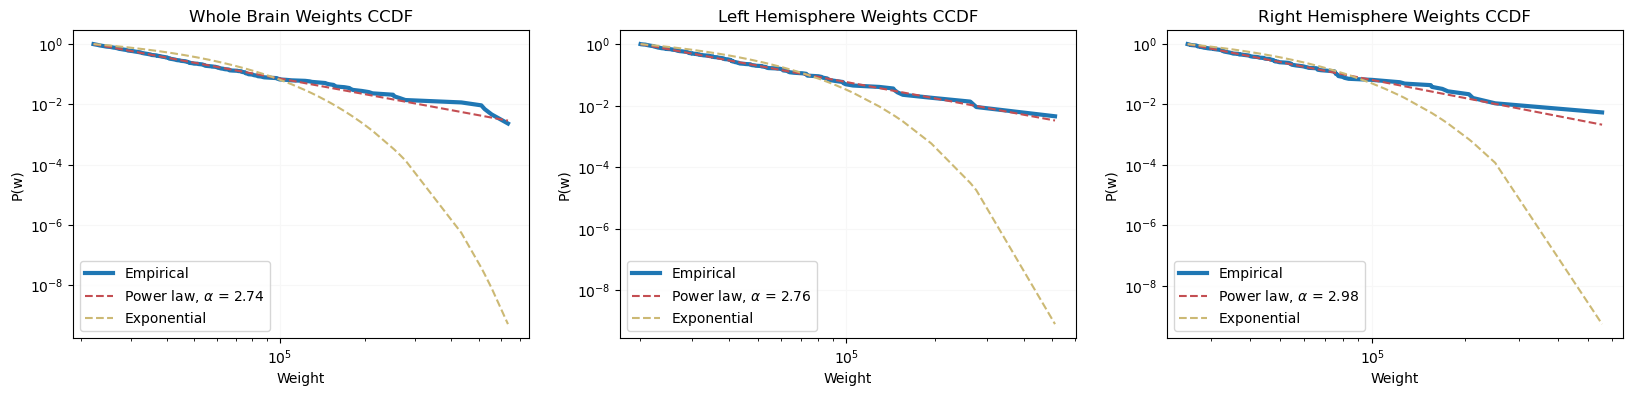

In [60]:
#COMPARISON WITH EXPONENTIAL CCDF DISTRIBUTION TO ASSES HEAVY TAILNESS OF THE DISTRIBUTIONS

fig = plt.figure(figsize = (20,4))
#fig.set_facecolor("#F7F7F7")

plt.subplot(1,3,1)

fig1 = results.plot_ccdf(linewidth=3, label = 'Empirical')  # original_data = 'True',
results.power_law.plot_ccdf(ax = fig1, color='r', linestyle='--', label= r'Power law, $\alpha$ = ' + str(np.round(alpha, 2)) )
#results.truncated_power_law.plot_ccdf(ax = fig1, color='m', linestyle='--', label= 'Truncated power law')
#results.stretched_exponential.plot_ccdf(ax = fig1, color='b', linestyle='--', label= 'Stretched exponential')
#results.lognormal_positive.plot_ccdf(ax = fig1, color='g', linestyle='--', label= 'Lognormal')
results.exponential.plot_ccdf(ax = fig1, color='y', linestyle='--', label= 'Exponential')
plt.grid(color = "#F7F7F7")
fig1.set_facecolor("white")
plt.setp(fig1.spines.values(), color='black')
#plt.xlim(32000,1000000)

plt.title('Whole Brain Weights CCDF')
plt.ylabel('P(w)')
plt.xlabel('Weight')
plt.legend(loc="lower left")
 
plt.subplot(1,3,2)
fig2 = results_left.plot_ccdf(linewidth=3, label = 'Empirical')  # original_data = 'True',
results_left.power_law.plot_ccdf(ax = fig2, color='r', linestyle='--', label= r'Power law, $\alpha$ = ' + str(np.round(alpha_left, 2)) )
#results_left.truncated_power_law.plot_ccdf(ax = fig2, color='m', linestyle='--', label= 'Truncated power law')
#results_left.stretched_exponential.plot_ccdf(ax = fig2, color='b', linestyle='--', label= 'Stretched exponential')
#results_left.lognormal_positive.plot_ccdf(ax = fig2, color='g', linestyle='--', label= 'Lognormal')
results_left.exponential.plot_ccdf(ax = fig2, color='y', linestyle='--', label= 'Exponential')
plt.grid(color = "#F7F7F7")
fig2.set_facecolor("white")
plt.setp(fig2.spines.values(), color='black')
#plt.xlim(57000,1000000)

plt.title('Left Hemisphere Weights CCDF')
plt.ylabel('P(w)')
plt.xlabel('Weight')
plt.legend(loc="lower left")


plt.subplot(1,3,3)
fig3 = results_right.plot_ccdf(linewidth=3, label = 'Empirical')  # original_data = 'True',
results_right.power_law.plot_ccdf(ax = fig3, color='r', linestyle='--', label= r'Power law, $\alpha$ = ' + str(np.round(alpha_right, 2)) )
#results_right.truncated_power_law.plot_ccdf(ax = fig3, color='m', linestyle='--', label= 'Truncated power law')
#results_right.stretched_exponential.plot_ccdf(ax = fig3, color='b', linestyle='--', label= 'Stretched exponential')
#results_right.lognormal_positive.plot_ccdf(ax = fig3, color='g', linestyle='--', label= 'Lognormal')
results_right.exponential.plot_ccdf(ax = fig3, color='y', linestyle='--', label= 'Exponential')
plt.grid(color = "#F7F7F7")
fig3.set_facecolor("white")
plt.setp(fig3.spines.values(), color='black')

plt.title('Right Hemisphere Weights CCDF')
plt.ylabel('P(w)')
plt.xlabel('Weight')
plt.legend(loc="lower left")
plt.locator_params(axis='x', numticks= 10)
#plt.xlim(32000,1000000)
#fig3.locator_params(tight=True, nbins=4)

#plt.savefig(r"C:\Users\leona\Leo_Python\haevytail_c.png")


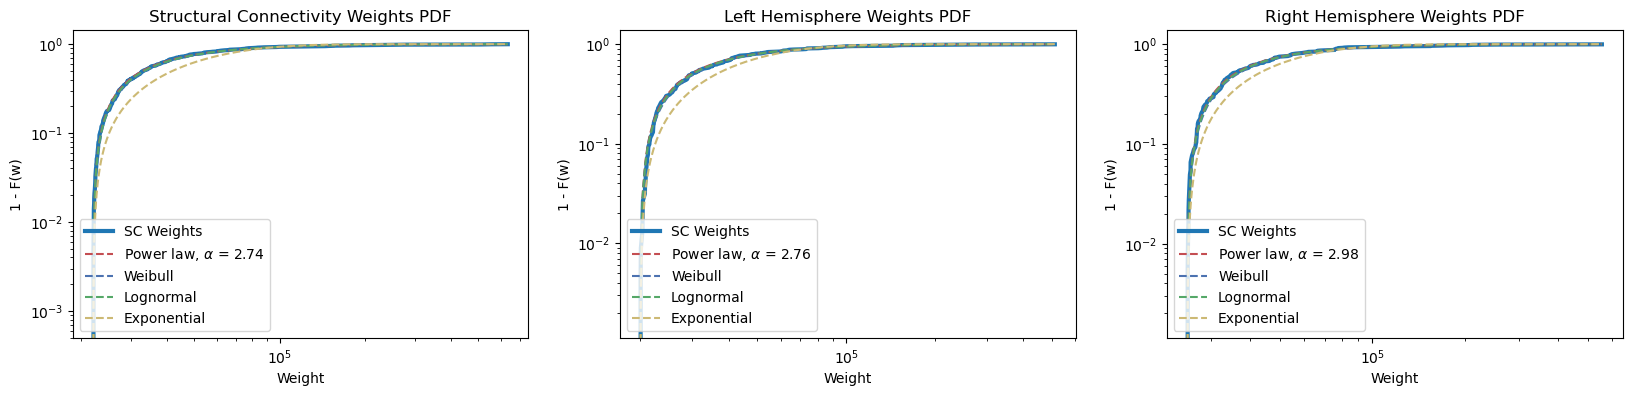

In [62]:
#COMPARISON CONSIDERING THE CDF DISTRBIUTION

plt.figure(figsize = (20,4))

plt.subplot(1,3,1)

fig1 = results.plot_cdf(linewidth=3, label = 'SC Weights')  # original_data = 'True',
results.power_law.plot_cdf(ax = fig1, color='r', linestyle='--', label= r'Power law, $\alpha$ = ' + str(np.round(alpha, 2)) )
results.stretched_exponential.plot_cdf(ax = fig1, color='b', linestyle='--', label= 'Weibull')
results.lognormal_positive.plot_cdf(ax = fig1, color='g', linestyle='--', label= 'Lognormal')
results.exponential.plot_cdf(ax = fig1, color='y', linestyle='--', label= 'Exponential')
plt.title('Structural Connectivity Weights PDF')
plt.ylabel('1 - F(w)')
plt.xlabel('Weight')
plt.legend(loc="lower left")

plt.subplot(1,3,2)
fig2 = results_left.plot_cdf(linewidth=3, label = 'SC Weights')  # original_data = 'True',
results_left.power_law.plot_cdf(ax = fig2, color='r', linestyle='--', label= r'Power law, $\alpha$ = ' + str(np.round(alpha_left, 2)) )
results_left.stretched_exponential.plot_cdf(ax = fig2, color='b', linestyle='--', label= 'Weibull')
results_left.lognormal_positive.plot_cdf(ax = fig2, color='g', linestyle='--', label= 'Lognormal')
results_left.exponential.plot_cdf(ax = fig2, color='y', linestyle='--', label= 'Exponential')
plt.title('Left Hemisphere Weights PDF')
plt.ylabel('1 - F(w)')
plt.xlabel('Weight')
plt.legend(loc="lower left")


plt.subplot(1,3,3)
fig3 = results_right.plot_cdf(linewidth=3, label = 'SC Weights')  # original_data = 'True',
results_right.power_law.plot_cdf(ax = fig3, color='r', linestyle='--', label= r'Power law, $\alpha$ = ' + str(np.round(alpha_right, 2)) )
results_right.stretched_exponential.plot_cdf(ax = fig3, color='b', linestyle='--', label= 'Weibull')
results_right.lognormal_positive.plot_cdf(ax = fig3, color='g', linestyle='--', label= 'Lognormal')
results_right.exponential.plot_cdf(ax = fig3, color='y', linestyle='--', label= 'Exponential')
plt.title('Right Hemisphere Weights PDF')
plt.ylabel('1 - F(w)')
plt.xlabel('Weight')
plt.legend(loc="lower left")

## Graph Analysis

In [64]:
#COMPUTE THE LOG(1+W) FOR THE CONNECTIVITY MATRIX

mat_log = np.log10(1 + matrix)
mat_log.max()

5.802551661603674

In [70]:
#discretize the connectome in 4 discrete values as in tvb default matrix

a = 1.5
b = 3
c = 4.5
mat_dis = np.zeros([379,379])

for i in range (379):
    for j in range (379):
        if mat_log[i,j] < a:
            mat_dis[i,j] = 0
        if mat_log[i,j] > c:
            mat_dis[i,j] = 3
        if a < mat_log[i,j] < b:
            mat_dis[i,j] = 1
        if b < mat_log[i,j] < c:
            mat_dis[i,j] = 2
mat_dis_l, mat_dis_r = emispheres(mat_dis)

In [68]:
def triangular(A):
    n = int(A.shape[0])
    m = int(n*(n-1)/2)
    tr = np.zeros([m])
    z = -1
    for i in range (1,n):
        for j in range (0,i):
            z = z + 1
            tr[z] =A[i,j]
    return tr

In [77]:
tvb_l = triangular(tvb[:38,:38])
tvb_r = triangular(tvb[38:,38:])
tvb_i = tvb[:38,38:]

mat_l = triangular(mat_dis[:180,:180])
mat_r = triangular(mat_dis[180:360,180:360])
mat_i = mat_dis[:180,180:360]



Text(0.5, 1.0, 'personalized connectome')

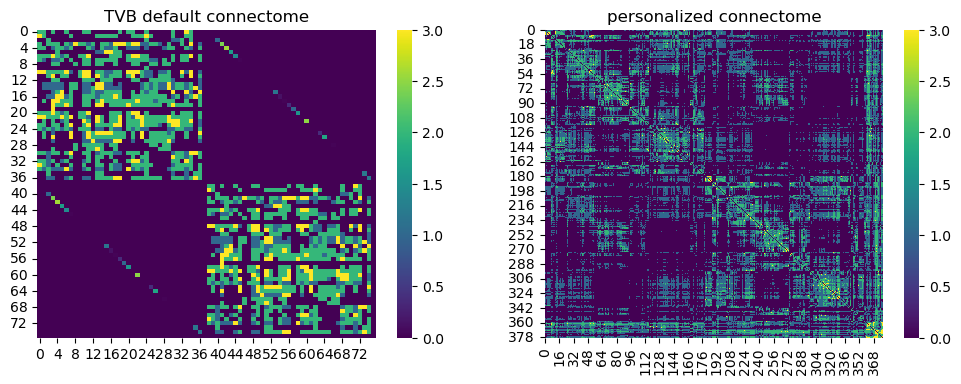

In [84]:
#COMPARISON OF INTERHEMISPHERIC CONNECTIVITY BETWEEN REALISTIC CONNECTOME AND TVB DEFAULT
plt.figure(figsize = (12,4))

plt.subplot(1,2,1)

sns.heatmap(data=tvb, cmap = 'viridis')
plt.title('TVB default connectome')

plt.subplot(1,2,2)

sns.heatmap(data=mat_dis, cmap = 'viridis')
plt.title('personalized connectome')

Text(0.5, 1.0, 'personalized interhemispheric connectome')

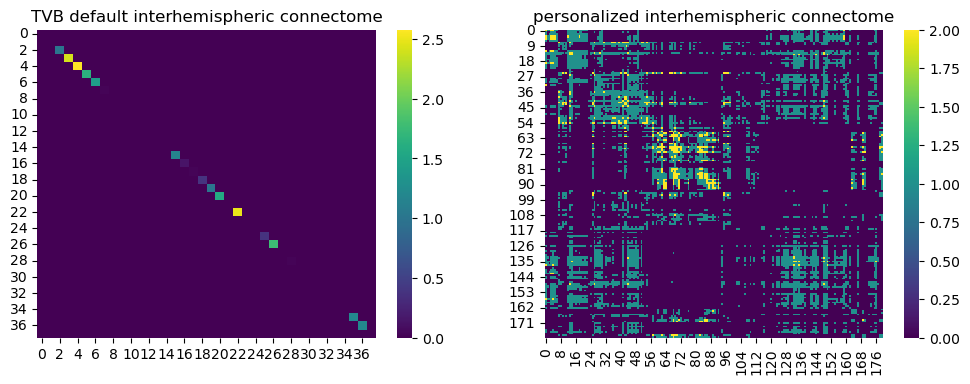

In [81]:
#COMPARISON OF INTERHEMISPHERIC CONNECTIVITY BETWEEN REALISTIC CONNECTOME AND TVB DEFAULT
plt.figure(figsize = (12,4))

plt.subplot(1,2,1)

sns.heatmap(data=tvb_i, cmap = 'viridis')
plt.title('TVB default interhemispheric connectome')

plt.subplot(1,2,2)

sns.heatmap(data=mat_i, cmap = 'viridis')
plt.title('personalized interhemispheric connectome')


Text(0.5, 1.0, 'ASD')

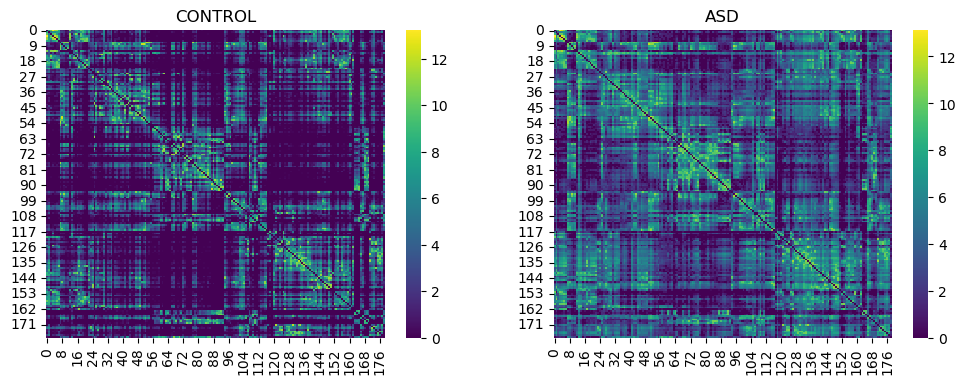

In [125]:
#COMPARISON OF INTRAHEMISPHERIC CONNECTIVITY BETWEEN ASD AND CONTROL
plt.figure(figsize = (12,4))

plt.subplot(1,2,1)

sns.heatmap(data=np.log(1+mat_control)[:179,:179], cmap = 'viridis')
plt.title('CONTROL')

plt.subplot(1,2,2)

sns.heatmap(data=np.log(1+matrix)[:179,:179], cmap = 'viridis')
plt.title('ASD')

Text(0.5, 1.0, 'Regularized Adjacency Matrix')

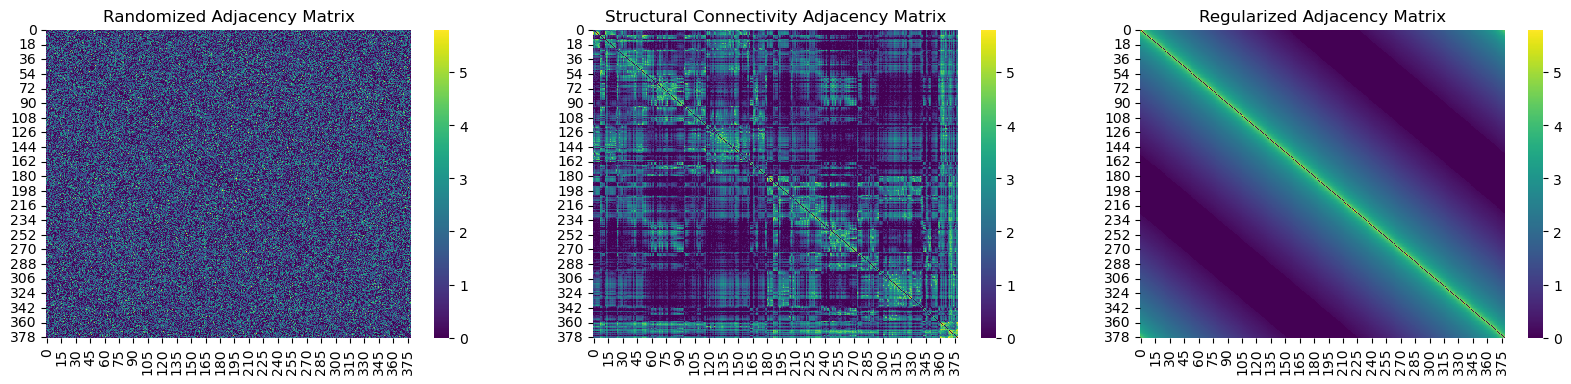

In [141]:
#CONSTRUCT NULL MODELS (RANDOMIZED AND REGULARIZED) FOR THE ADJACENCY MATRIX

plt.figure(figsize = (20,4))

plt.subplot(1,3,2)
sns.heatmap(data=mat_log, cmap = 'viridis')
plt.title('Structural Connectivity Adjacency Matrix')

plt.subplot(1,3,1)

B = swp.randomize_matrix(mat_log)
sns.heatmap(data=B, cmap = 'viridis')
plt.title('Randomized Adjacency Matrix')
plt.subplot(1,3,3)
r = swp.get_avg_rad_eff(mat_log)
C = swp.regular_matrix_generator(mat_log ,r)
sns.heatmap(data=C, cmap = 'viridis')
plt.title('Regularized Adjacency Matrix')
#plt.savefig(r"C:\Users\leona\Leo_Python\randomization.png")

In [126]:
#GRAPH ANALYSIS PIPELINE- BINARIZATION WITH DIFFERENT THRESHOLDS - GRAPH COSTRUCTION - GRAPH METRICS - CONTROL CONNECTOME

perc_i = 70
perc_f = 98
n_trial = perc_f - perc_i

density_c = np.zeros([n_trial])
density_c_l = np.zeros([n_trial])
density_c_r = np.zeros([n_trial])
small_world_c = np.zeros([n_trial])
small_world_c_l = np.zeros([n_trial])
small_world_c_r = np.zeros([n_trial])
size_c = np.zeros([n_trial])
size_c_l = np.zeros([n_trial])
size_c_r = np.zeros([n_trial])
sw_c = np.zeros([1,11,n_trial])
sw_c_l = np.zeros([1,11,n_trial])
sw_c_r = np.zeros([1,11,n_trial])


n_test = 1
channels_h = 189
Hl_rem = np.zeros([channels_h,channels_h, n_test])
Hr_rem = np.zeros([channels_h,channels_h,n_test])
sw_l_test = np.zeros([1,11,n_trial,n_test])
sw_r_test = np.zeros([1,11,n_trial,n_test])
    
    
#binarized the connectivity matrix selecting the percentile

w = -1
for k in range (perc_i,perc_f):
    w = w +1
    matr = mat_c
    channels= matr.shape[0]
    percentile = k
    a = np.percentile(matr,percentile)
    z = 0
    A = np.zeros([channels,channels])
    #binarize
    for i in range (channels):
        for j in range (channels):
            if matr[i,j] > a:
                A[i,j] = 1
                z = z +1 
            else:
                A[i,j] = 0
    
    Hl,Hr = emispheres(A)
    channels_h = Hl.shape[0]
    density_c[w] = z/(channels*(channels - 1))
    g=nx.from_numpy_array(A)
    g_l = nx.from_numpy_array(Hl)
    g_r = nx.from_numpy_array(Hr)
    comps = list(nx.connected_components(g)) # get a list of connected components (for decreasing size)
    comps_l = list(nx.connected_components(g_l)) # get a list of connected components (for decreasing size)
    comps_r = list(nx.connected_components(g_r)) # get a list of connected components (for decreasing size)
    comp_0 = nx.subgraph(g, comps[0]) # build a subgraph on the first component
    comp_0_l = nx.subgraph(g_l, comps_l[0]) # build a subgraph on the first component
    comp_0_r = nx.subgraph(g_r, comps_r[0]) # build a subgraph on the first component
    size[w] = comp_0.number_of_nodes()
    size_l[w] = comp_0_l.number_of_nodes()
    size_r[w] = comp_0_r.number_of_nodes()
    
    #randomly remove nodes to test differences in networks metrics - change the parameter n_test to implement this part


    for r in range (n_test):
        for i in range (channels_h):
            for j in range (channels_h):
                a = random.randint(1,1000)            
                if a > 100: 
                    Hl_rem[i,j,r] = Hl[i,j]
                    Hr_rem[i,j,r] = Hr[i,j]

        small_world_l_test = swp.small_world_propensity(Hl_rem[:,:,r])
        small_world_r_test = swp.small_world_propensity(Hr_rem[:,:,r])
        sw_l_test[:,:,w,r] = small_world_l_test.to_numpy()
        sw_r_test[:,:,w,r] = small_world_r_test.to_numpy()

        
    
        #compute the density of the emispheres
    z = 0
    for i in range (channels_h):
        for j in range (channels_h):
            if Hl[i,j] > 0:
                z = z +1 
    density_c_l[w] = z/(channels_h*(channels_h - 1))
    z = 0
    for i in range (channels_h):
        for j in range (channels_h):
            if Hr[i,j] > 0:
                z = z +1
    density_c_r[w] = z/(channels_h*(channels_h - 1))

    #compute smallworldness
    small_world, small_world_l, small_world_r = swp.small_world_propensity(A), swp.small_world_propensity(Hl), swp.small_world_propensity(Hr)
    sw_c[:,:,w], sw_c_l[:,:,w], sw_c_r[:,:,w] = small_world.to_numpy(), small_world_l.to_numpy(), small_world_r.to_numpy()


In [127]:
#GRAPH ANALYSIS PIPELINE- BINARIZATION WITH DIFFERENT THRESHOLDS - GRAPH COSTRUCTION - GRAPH METRICS - ASD CONNECTOME

perc_i = 70
perc_f = 98
n_trial = perc_f - perc_i

density = np.zeros([n_trial])
density_l = np.zeros([n_trial])
density_r = np.zeros([n_trial])
small_world = np.zeros([n_trial])
small_world_l = np.zeros([n_trial])
small_world_r = np.zeros([n_trial])
size = np.zeros([n_trial])
size_l = np.zeros([n_trial])
size_r = np.zeros([n_trial])
sw = np.zeros([1,11,n_trial])
sw_l = np.zeros([1,11,n_trial])
sw_r = np.zeros([1,11,n_trial])


n_test = 1
channels_h = 189
Hl_rem = np.zeros([channels_h,channels_h, n_test])
Hr_rem = np.zeros([channels_h,channels_h,n_test])
sw_l_test = np.zeros([1,11,n_trial,n_test])
sw_r_test = np.zeros([1,11,n_trial,n_test])
    
    
#binarized the connectivity matrix selecting the percentile

w = -1
for k in range (perc_i,perc_f):
    w = w +1
    matrix = matrix
    channels= matrix.shape[0]
    percentile = k
    a = np.percentile(matrix,percentile)
    z = 0
    A = np.zeros([channels,channels])
    #binarize
    for i in range (channels):
        for j in range (channels):
            if matrix[i,j] > a:
                A[i,j] = 1
                z = z +1 
            else:
                A[i,j] = 0
    
    Hl,Hr = emispheres(A)
    channels_h = Hl.shape[0]
    density[w] = z/(channels*(channels - 1))
    g=nx.from_numpy_array(A)
    g_l = nx.from_numpy_array(Hl)
    g_r = nx.from_numpy_array(Hr)
    comps = list(nx.connected_components(g)) # get a list of connected components (for decreasing size)
    comps_l = list(nx.connected_components(g_l)) # get a list of connected components (for decreasing size)
    comps_r = list(nx.connected_components(g_r)) # get a list of connected components (for decreasing size)
    comp_0 = nx.subgraph(g, comps[0]) # build a subgraph on the first component
    comp_0_l = nx.subgraph(g_l, comps_l[0]) # build a subgraph on the first component
    comp_0_r = nx.subgraph(g_r, comps_r[0]) # build a subgraph on the first component
    size[w] = comp_0.number_of_nodes()
    size_l[w] = comp_0_l.number_of_nodes()
    size_r[w] = comp_0_r.number_of_nodes()
    
    #randomly remove nodes to test differences in networks metrics


    for r in range (n_test):
        for i in range (channels_h):
            for j in range (channels_h):
                a = random.randint(1,1000)            
                if a > 100: 
                    Hl_rem[i,j,r] = Hl[i,j]
                    Hr_rem[i,j,r] = Hr[i,j]

        small_world_l_test = swp.small_world_propensity(Hl_rem[:,:,r])
        small_world_r_test = swp.small_world_propensity(Hr_rem[:,:,r])
        sw_l_test[:,:,w,r] = small_world_l_test.to_numpy()
        sw_r_test[:,:,w,r] = small_world_r_test.to_numpy()

        
    
        #compute the density of the emispheres
    z = 0
    for i in range (channels_h):
        for j in range (channels_h):
            if Hl[i,j] > 0:
                z = z +1 
    density_l[w] = z/(channels_h*(channels_h - 1))
    z = 0
    for i in range (channels_h):
        for j in range (channels_h):
            if Hr[i,j] > 0:
                z = z +1
    density_r[w] = z/(channels_h*(channels_h - 1))

    #compute smallworldness
    small_world, small_world_l, small_world_r = swp.small_world_propensity(A), swp.small_world_propensity(Hl), swp.small_world_propensity(Hr)
    sw[:,:,w], sw_l[:,:,w], sw_r[:,:,w] = small_world.to_numpy(), small_world_l.to_numpy(), small_world_r.to_numpy()


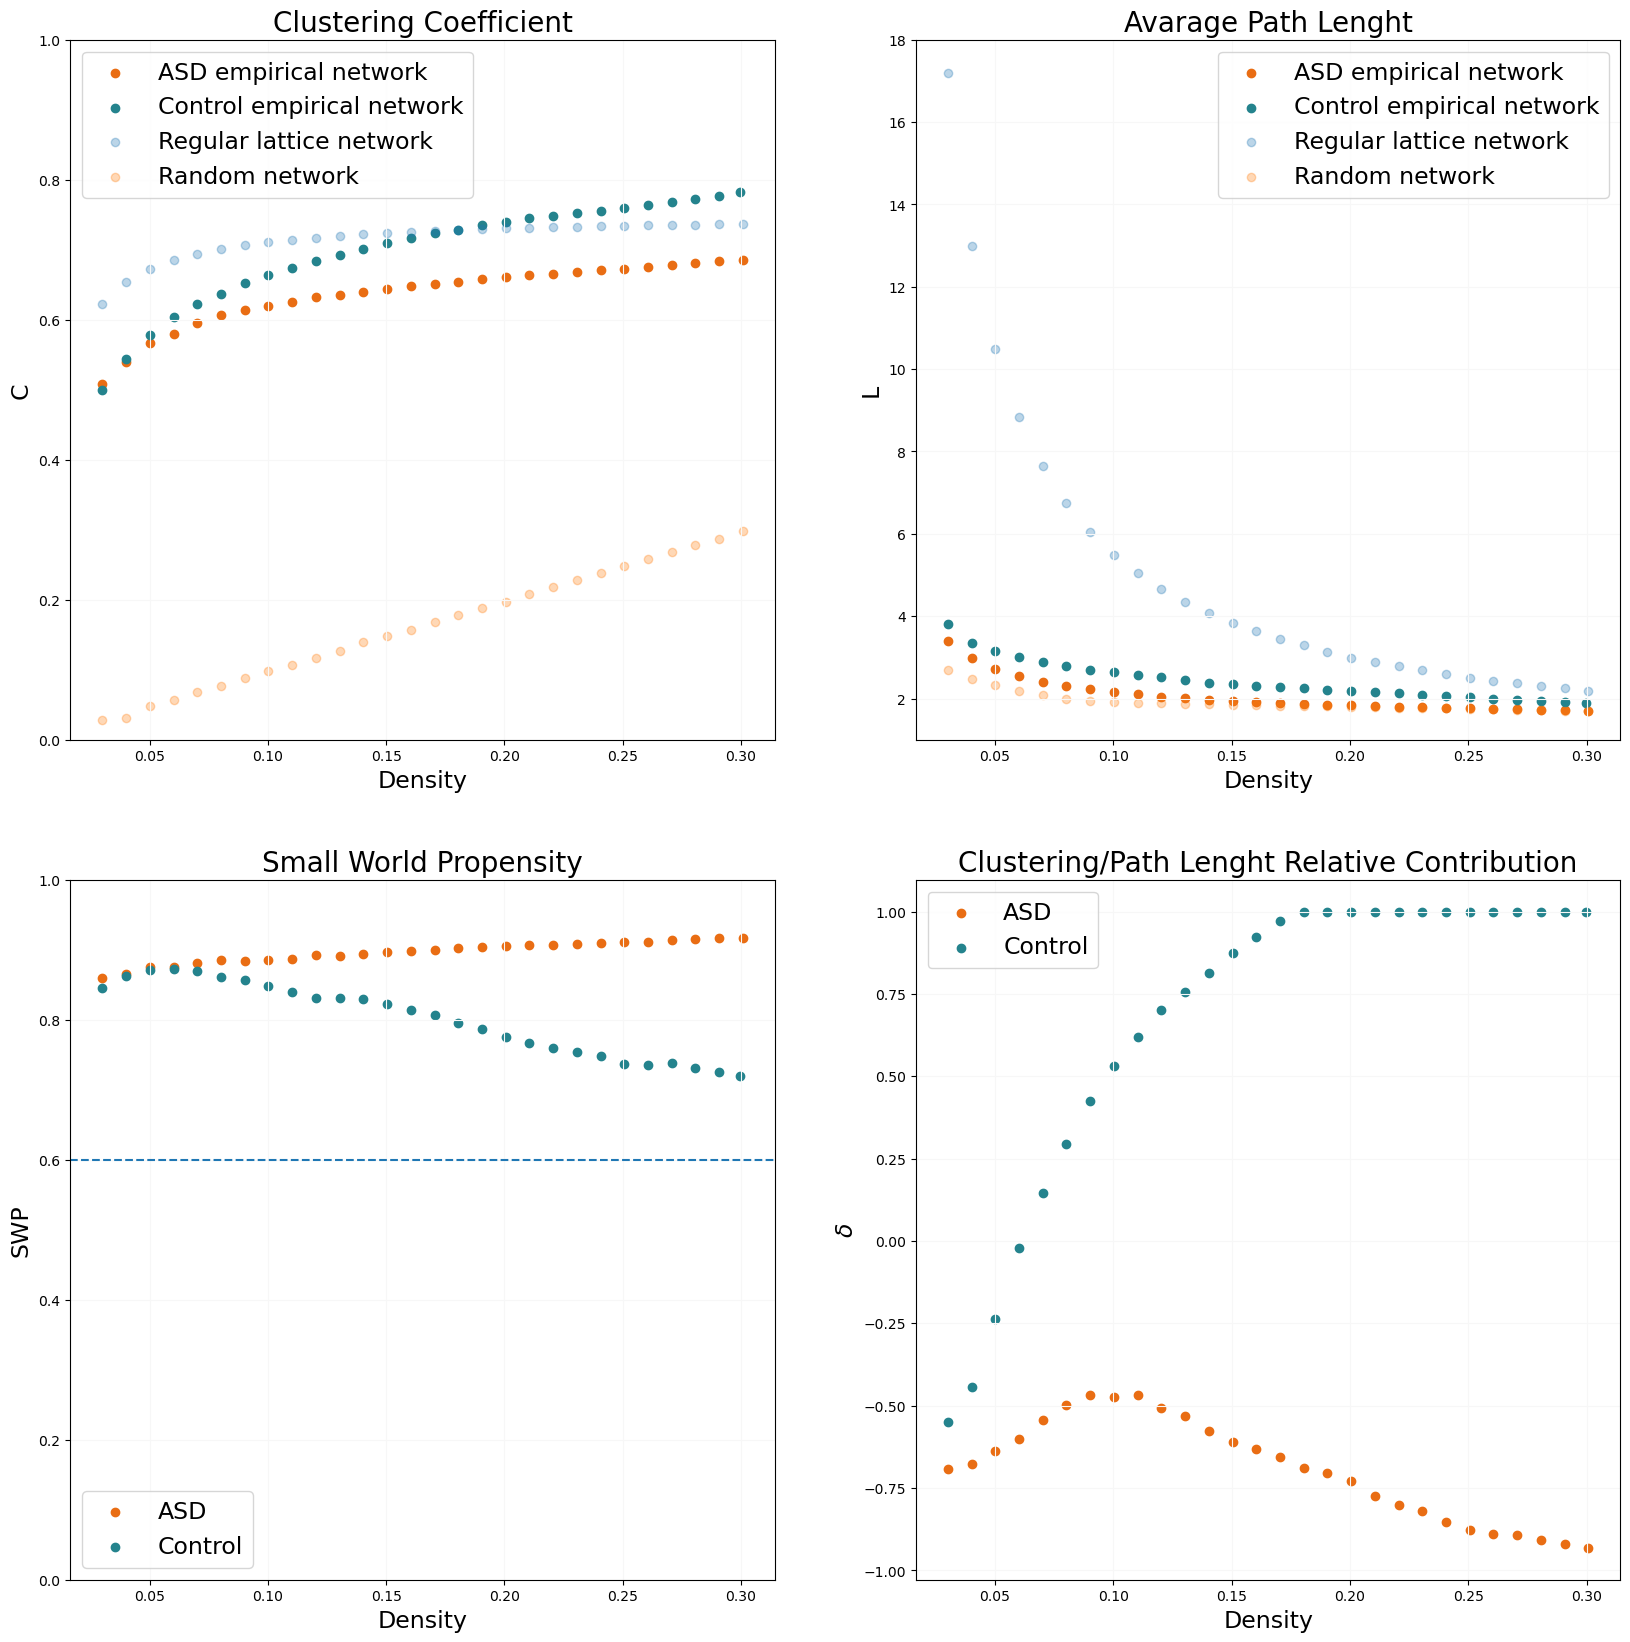

In [137]:
#GRAPH THEORY COMPARISON - WHOLE BRAIN - CONTROL VS ASD VS NULL MODELS

plt.figure(figsize = (20,20))

fig1 = plt.subplot(2,2,1)
plt.scatter(density,sw[0,0,:], label = 'ASD empirical network', color = colors[1])
plt.scatter(density_c,sw_c[0,0,:], label = 'Control empirical network', color = colors[0])
plt.scatter(density,sw[0,7,:], label = 'Regular lattice network', alpha = 0.3)
plt.scatter(density,sw[0,8,:], label = 'Random network', alpha = 0.3)
plt.ylim(0,1)
#plt.xlim(0,0.6)
plt.title('Clustering Coefficient',fontsize = 20)
plt.ylabel(r'C',fontsize = 17)
plt.legend(loc= 'best')
plt.legend(fontsize=17)
plt.xlabel('Density',fontsize = 17)
plt.grid(color = "#F7F7F7")



fig2 = plt.subplot(2,2,2)


plt.scatter(density,sw[0,1,:], label = 'ASD empirical network', color = colors[1])
plt.scatter(density_c,sw_c[0,1,:], label = 'Control empirical network', color = colors[0])
plt.scatter(density,sw[0,9,:], label = 'Regular lattice network', alpha = 0.3)
plt.scatter(density,sw[0,10,:], label = 'Random network', alpha = 0.3)

plt.ylim(1,18)
plt.title('Avarage Path Lenght',fontsize = 20)
plt.ylabel(r'L',fontsize = 17)
plt.legend(loc= 'best')
plt.legend(fontsize=17)
plt.xlabel('Density',fontsize = 17)
plt.grid(color = "#F7F7F7")


fig3 = plt.subplot(2,2,3)
plt.scatter(density,sw[0,4,:], label = 'ASD', color = colors[1])
plt.scatter(density_c,sw_c[0,4,:], label = 'Control', color = colors[0])
#plt.scatter(density_l,sw_l[0,4,:], label = 'left hemisphere')
#plt.scatter(density_r,sw_r[0,4,:], label = 'right hemisphere')
#plt.legend(loc="best")
plt.axhline(0.6, ls = '--')
plt.title(r'Small World Propensity',fontsize = 20)
plt.ylabel(r'SWP',fontsize = 17)
plt.ylim(0,1)
plt.xlabel('Density',fontsize = 17)
plt.grid(color = "#F7F7F7")
plt.legend(fontsize=17)

fig4 = plt.subplot(2,2,4)

plt.scatter(density,sw[0,6,:], label = 'ASD', color = colors[1])
plt.scatter(density_c,sw_c[0,6,:], label = 'Control', color = colors[0])
#plt.scatter(density_l,sw_l[0,6,:], label = 'left hemisphere')
#plt.scatter(density_r,sw_r[0,6,:], label = 'right hemisphere')
#plt.legend(loc="best")
#plt.ylim(-1,1)
plt.title(r'Clustering/Path Lenght Relative Contribution',fontsize = 20)
plt.ylabel(r'$\delta$',fontsize = 17)
plt.xlabel('Density',fontsize = 17)
plt.grid(color = "#F7F7F7")
plt.legend(fontsize=17)

#plt.savefig(r"C:\Users\leona\Leo_Python\small_world_propensity.pdf")

[None, None, None, None]

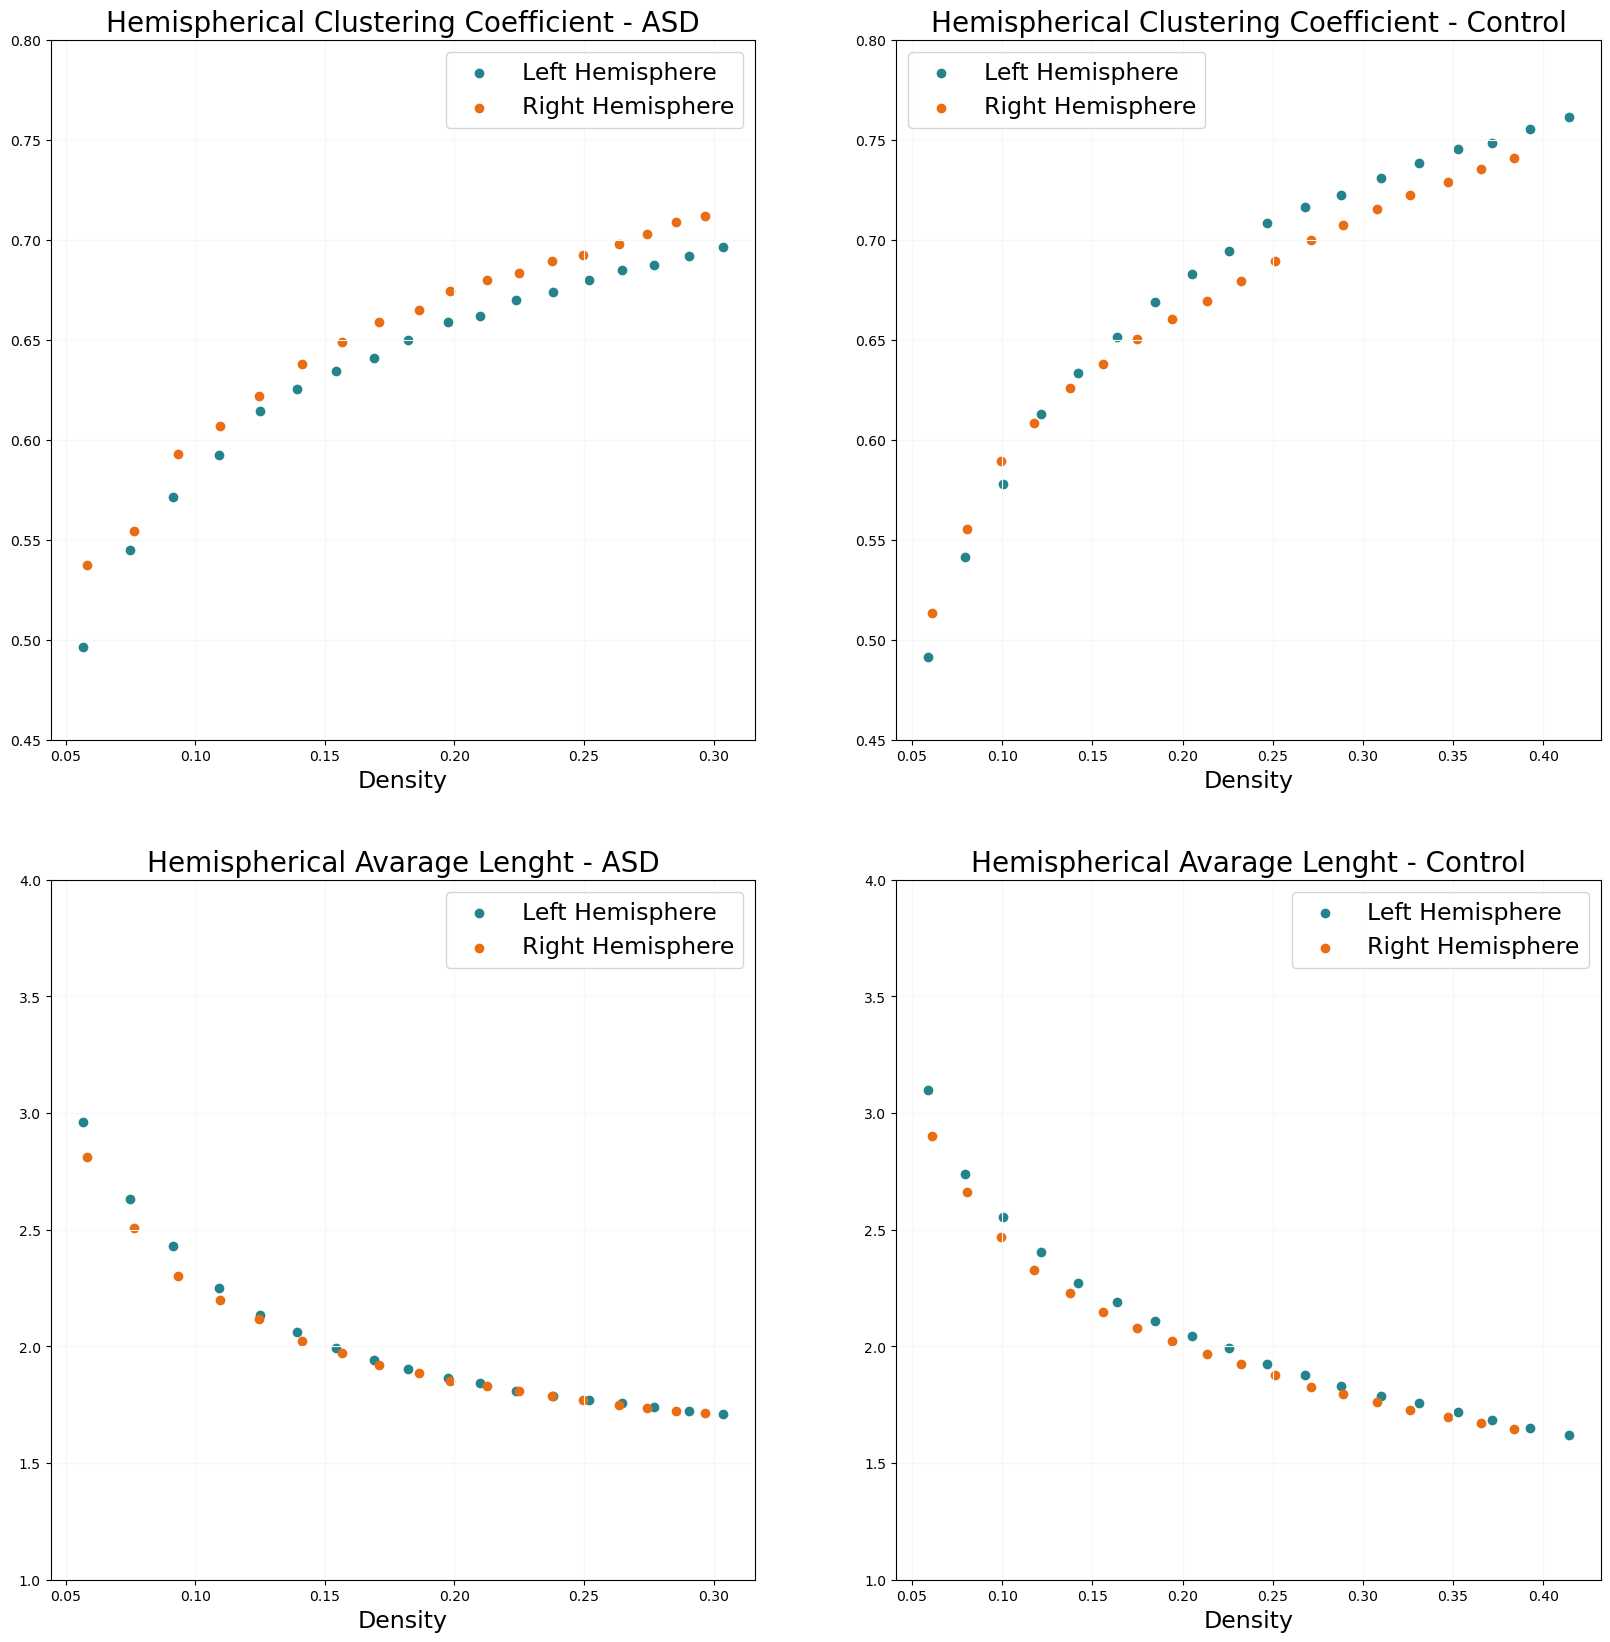

In [140]:
#GRAPH THEORY COMPARISON - HEMISPHERICAL ASYMMETRY- CONTROL VS ASD 


#select number of points to be plotted, ie where to cut the density
n = 10
plt.figure(figsize = (20,20))

fig1 = plt.subplot(2,2,1)

plt.scatter(density_l[n:],sw_l[0,0,n:], label = 'Left Hemisphere', color = colors[0])
plt.scatter(density_r[n:],sw_r[0,0,n:], label = 'Right Hemisphere', color = colors[1])

plt.title('Hemispherical Clustering Coefficient - ASD',fontsize = 20)
plt.legend(loc= 'best')
plt.legend(fontsize=17)
plt.xlabel('Density',fontsize = 17)
plt.grid(color = "#F7F7F7")
fig1.set_facecolor("white")
plt.setp(fig1.spines.values(), color='black')
plt.ylim(0.45,0.8)
fig2 = plt.subplot(2,2,2)


plt.scatter(density_c_l[n:],sw_c_l[0,0,n:], label = 'Left Hemisphere', color = colors[0])
plt.scatter(density_c_r[n:],sw_c_r[0,0,n:], label = 'Right Hemisphere', color = colors[1])

plt.title('Hemispherical Clustering Coefficient - Control',fontsize = 20)
plt.legend(loc= 'best')
plt.legend(fontsize=17)
plt.xlabel('Density',fontsize = 17)
plt.grid(color = "#F7F7F7")
fig1.set_facecolor("white")
plt.setp(fig1.spines.values(), color='black')
plt.ylim(0.45,0.8)

fig3 = plt.subplot(2,2,3)
plt.scatter(density_l[n:],sw_l[0,1,n:], label = 'Left Hemisphere', color = colors[0])
plt.scatter(density_r[n:],sw_r[0,1,n:], label = 'Right Hemisphere', color = colors[1])
plt.ylim(1,4)
plt.title('Hemispherical Avarage Lenght - ASD',fontsize = 20)
plt.legend(loc= 'best')
plt.legend(fontsize=17)

plt.xlabel('Density',fontsize = 17)
plt.grid(color = "#F7F7F7")
fig2.set_facecolor("white")
plt.setp(fig2.spines.values(), color='black')

fig4 = plt.subplot(2,2,4)

plt.scatter(density_c_l[n:],sw_c_l[0,1,n:], label = 'Left Hemisphere', color = colors[0])
plt.scatter(density_c_r[n:],sw_c_r[0,1,n:], label = 'Right Hemisphere', color = colors[1])
plt.ylim(1,4)
plt.title('Hemispherical Avarage Lenght - Control',fontsize = 20)
plt.legend(loc= 'best')
plt.legend(fontsize=17)

plt.xlabel('Density',fontsize = 17)
plt.grid(color = "#F7F7F7")
fig2.set_facecolor("white")
plt.setp(fig2.spines.values(), color='black')
#plt.savefig(r"C:\Users\leona\Leo_Python\small_world_propensity_hemispheres3.png")

[None, None, None, None]

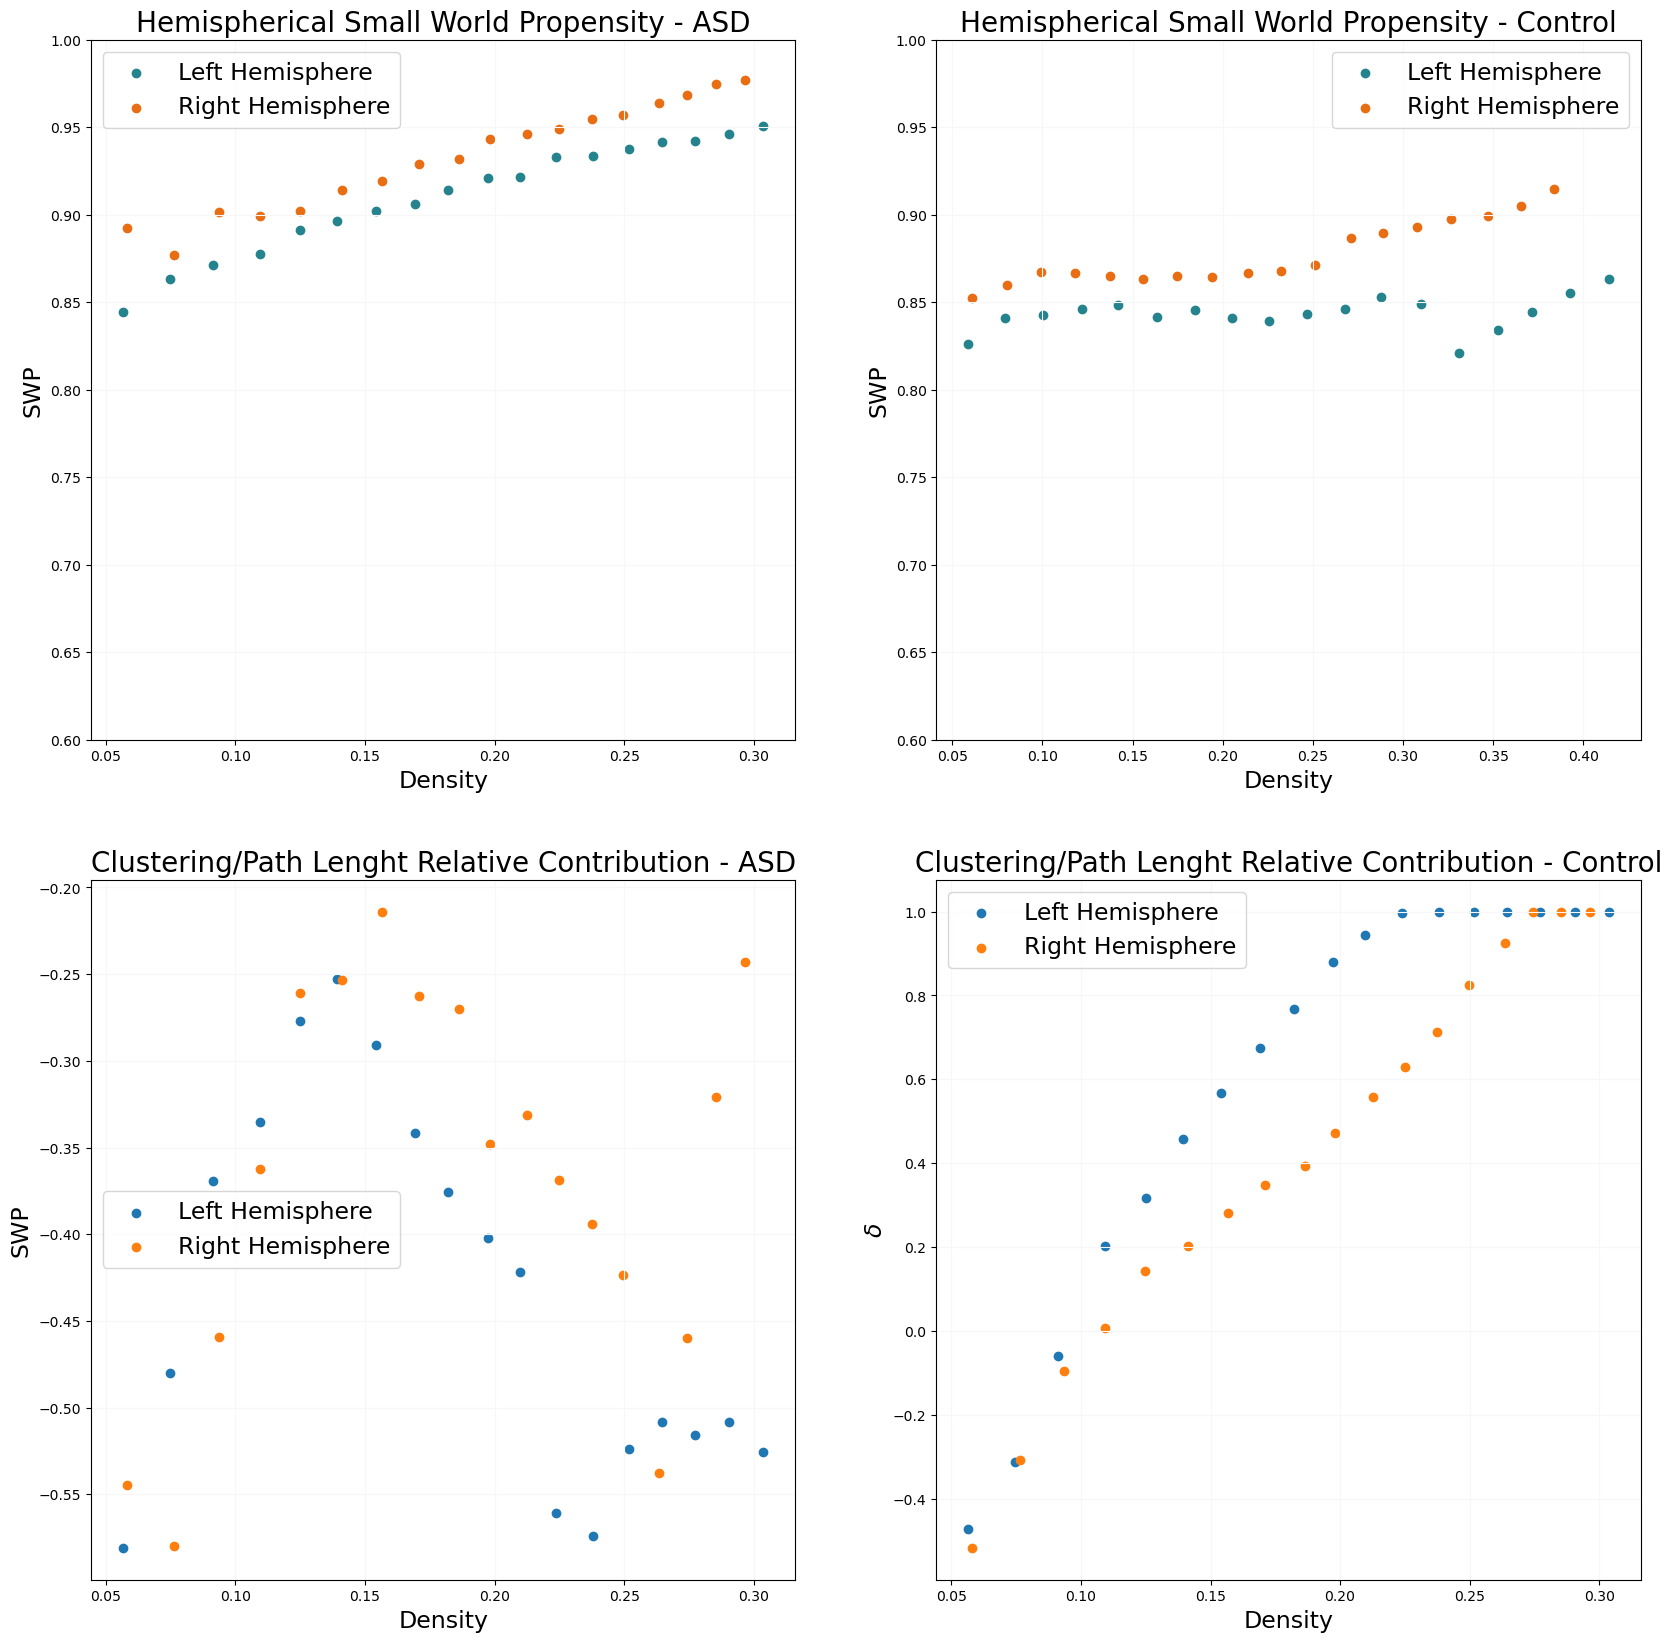

In [139]:
#GRAPH THEORY COMPARISON - HEMISPHERICAL ASYMMETRY- CONTROL VS ASD 


plt.figure(figsize = (20,20))

fig1 = plt.subplot(2,2,1)

plt.scatter(density_l[n:],sw_l[0,4,n:], label = 'Left Hemisphere', color = colors[0])
plt.scatter(density_r[n:],sw_r[0,4,n:], label = 'Right Hemisphere', color = colors[1])
plt.title(r'Hemispherical Small World Propensity - ASD',fontsize = 20)
plt.ylabel(r'SWP',fontsize = 17)
plt.xlabel('Density',fontsize = 17)
plt.legend(loc="best")
plt.legend(fontsize=17)
plt.ylim(0.6,1)
plt.grid(color = "#F7F7F7")
fig3.set_facecolor("white")
plt.setp(fig3.spines.values(), color='black')

fig2 = plt.subplot(2,2,2)

plt.scatter(density_c_l[n:],sw_c_l[0,4,n:], label = 'Left Hemisphere', color = colors[0])
plt.scatter(density_c_r[n:],sw_c_r[0,4,n:], label = 'Right Hemisphere', color = colors[1])
plt.title(r'Hemispherical Small World Propensity - Control',fontsize = 20)
plt.ylabel(r'SWP',fontsize = 17)
plt.xlabel('Density',fontsize = 17)
plt.legend(loc="best")
plt.legend(fontsize=17)
plt.ylim(0.6,1)
plt.grid(color = "#F7F7F7")
fig3.set_facecolor("white")
plt.setp(fig3.spines.values(), color='black')

fig3 = plt.subplot(2,2,3)

plt.scatter(density_l[n:],sw_l[0,6,n:], label = 'Left Hemisphere')
plt.scatter(density_r[n:],sw_r[0,6,n:], label = 'Right Hemisphere')
plt.title(r'Clustering/Path Lenght Relative Contribution - ASD',fontsize = 20)
plt.ylabel(r'SWP',fontsize = 17)
plt.xlabel('Density',fontsize = 17)
plt.legend(loc="best")
plt.legend(fontsize=17)
plt.grid(color = "#F7F7F7")
fig3.set_facecolor("white")
plt.setp(fig3.spines.values(), color='black')

fig4 = plt.subplot(2,2,4)

plt.scatter(density_l[n:],sw_c_l[0,6,n:], label = 'Left Hemisphere')
plt.scatter(density_r[n:],sw_c_r[0,6,n:], label = 'Right Hemisphere')
plt.legend(loc="best")
plt.legend(fontsize=17)
plt.title(r'Clustering/Path Lenght Relative Contribution - Control',fontsize = 20)
plt.ylabel(r'$\delta$',fontsize = 17)
plt.xlabel('Density',fontsize = 17)
plt.grid(color = "#F7F7F7")
fig4.set_facecolor("white")
plt.setp(fig4.spines.values(), color='black')
#plt.savefig(r"C:\Users\leona\Leo_Python\small_world_propensity_hemispheres2.png")